In [34]:
# import statements
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

## Data Preprocessing

In [3]:
#Load the final merged data
stock_news_merged_data = pd.read_csv('Data/final_merged_data.csv')
stock_news_merged_data.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,Title,Published Date,Sentiment Score,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,2025-03-25,EQ,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09","2,006.45","1,358.35","98,90,140","16,08,22,64,118.35","2,66,112","Infosys, Wipro, TCS among tech giants blacklis...",2025-03-25,0.701625,True,False,False
1,2025-03-25,EQ,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09","2,006.45","1,358.35","98,90,140","16,08,22,64,118.35","2,66,112",Jefferies says 'buy' Infosys on attractive ris...,2025-03-25,0.517249,False,True,False
2,2025-03-25,EQ,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09","2,006.45","1,358.35","98,90,140","16,08,22,64,118.35","2,66,112",Infosys shares rise nearly 3% despite Jefferie...,2025-03-25,0.918781,False,False,True
3,2025-03-25,EQ,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09","2,006.45","1,358.35","98,90,140","16,08,22,64,118.35","2,66,112","TCS, HCLTech, Infosys, Wipro: Why IT stocks ar...",2025-03-25,0.713755,False,True,False
4,2025-03-25,EQ,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09","2,006.45","1,358.35","98,90,140","16,08,22,64,118.35","2,66,112","Stock Recommendations Today: Suzlon Energy, LI...",2025-03-25,0.951364,False,True,False


In [4]:
# check for null values
stock_news_merged_data.isna().sum().sum()

np.int64(0)

In [5]:
# remove unnecessary columns
stock_news_merged_data.drop(columns = ['Date', 'series', 'Title','Published Date', '52W H', '52W L', 'VOLUME', 'VALUE', 'No of trades'], inplace = True)
stock_news_merged_data.head()

,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,Sentiment Score,Sentiment_negative,Sentiment_neutral,Sentiment_positive
0,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09",0.701625,True,False,False
1,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09",0.517249,False,True,False
2,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09",0.918781,False,False,True
3,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09",0.713755,False,True,False
4,"1,605.00","1,636.15","1,605.00","1,592.75","1,619.25","1,628.45","1,626.09",0.951364,False,True,False


In [6]:
# inspect the dtypes
stock_news_merged_data.dtypes

OPEN                   object
HIGH                   object
LOW                    object
PREV. CLOSE            object
ltp                    object
close                  object
vwap                   object
Sentiment Score       float64
Sentiment_negative       bool
Sentiment_neutral        bool
Sentiment_positive       bool
dtype: object

In [7]:
# Convert the numerical columns to floating point numbers
columns_to_convert = ['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'ltp', 'close', 'vwap']

for column in columns_to_convert:
    stock_news_merged_data[column] = stock_news_merged_data[column].astype(str)  # Ensure all values are strings
    stock_news_merged_data[column] = stock_news_merged_data[column].str.replace(r"[^\d.]", "", regex=True)  # Remove non-numeric chars
    stock_news_merged_data[column] = pd.to_numeric(stock_news_merged_data[column], errors="coerce")  # Convert to float, leave NaN for non-convertible values

# Check if conversion is successful
stock_news_merged_data.dtypes

OPEN                  float64
HIGH                  float64
LOW                   float64
PREV. CLOSE           float64
ltp                   float64
close                 float64
vwap                  float64
Sentiment Score       float64
Sentiment_negative       bool
Sentiment_neutral        bool
Sentiment_positive       bool
dtype: object

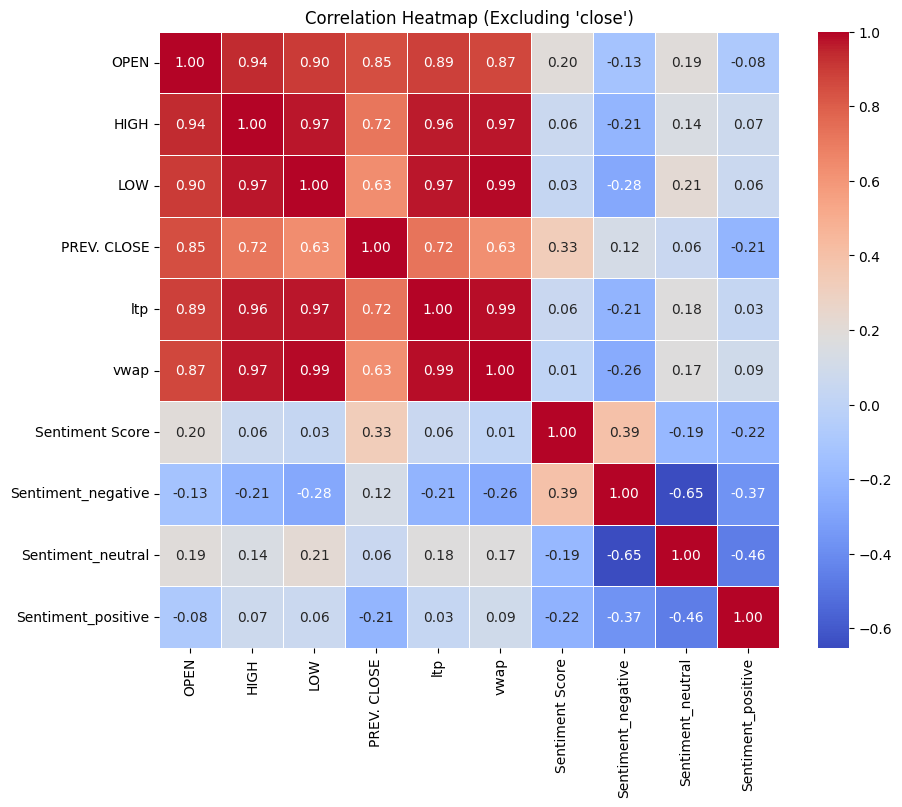

In [15]:
# Drop the 'close' column and display the correlation matrix
corr_matrix = stock_news_merged_data.drop(columns=['close']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Excluding 'close')")
plt.show()

This correlation matrix provides insights into how the variables in your stock market dataset are interrelated. Here's a concise interpretation:

1. **Market Variables**: `OPEN`, `HIGH`, `LOW`, `LTP` (last traded price), and `VWAP` (volume-weighted average price) show strong positive correlations with each other, meaning these variables tend to move together. This is expected in stock market data, as they are closely related.

2. **Previous Close**: `PREV. CLOSE` has moderate positive correlations with the above market variables, suggesting its influence but not as strong as the real-time metrics.

3. **Sentiment Variables**:
   - `Sentiment Score` has weak positive correlations with most market variables, indicating a slight influence of sentiment on stock movements.
   - `Sentiment_negative` shows weak to moderate negative correlations with key market variables, suggesting that negative sentiment might slightly impact stock performance negatively.
   - `Sentiment_neutral` and `Sentiment_positive` have weak correlations with market variables, indicating limited direct impact.

In [16]:
# split the dataset
X = stock_news_merged_data.drop('close', axis = 1)
y = stock_news_merged_data['close']

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.075, random_state=40)

In [ ]:
X_test.shape # 6 rows for evaluation

(6, 10)

## Model Training

In [26]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest
    'max_depth': [10, 20, 30, None],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
}

# Create the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=40)

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all cores for faster computation
                           verbose=2,  # Show detailed information
                           scoring='neg_mean_squared_error')  # Use MSE for scoring

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\abhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
106 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\abhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\abhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=40), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [28]:
# Output the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")

# Use the best estimator for further predictions
best_rf_model = grid_search.best_estimator_

# Check the model performance on the training data
train_score = best_rf_model.score(X_train, y_train)
print(f"Training R^2 score: {train_score:.2f}")

# Evaluate on the test set
test_score = best_rf_model.score(X_test, y_test)
print(f"Test R^2 score: {test_score:.2f}")

Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training R^2 score: 1.00
Test R^2 score: 1.00


In [29]:
# inspect on test data
y_pred = best_rf_model.predict(X_test)

comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

comparison_df.head()

,Actual,Predicted
45,1615.55,1615.55000
0,1628.45,1628.32100
63,1590.85,1593.20475
52,1586.55,1586.28050
26,1592.55,1592.46150


It can be seen that the prediction is very close to accurate

In [32]:
#Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) **0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.9403251770829738
R-squared (R2): 0.996026216682359
Root Mean Squared Error (RMSE): 0.9697036542588534
Mean Absolute Error (MAE): 0.47362500000266056


The model's performance is quite strong, as indicated by the evaluation metrics:

- **Mean Squared Error (MSE) = 0.94** and **Root Mean Squared Error (RMSE) = 0.97** suggest that the average squared and absolute errors in predictions are low, meaning the model makes relatively small mistakes.
- **Mean Absolute Error (MAE) = 0.47** indicates that, on average, the predicted closing price deviates by around 0.47 units from the actual value.
- **R-squared (R²) = 0.996** signifies that 99.6% of the variance in the stock's closing price is explained by the model, demonstrating excellent predictive power.

Overall, the model performs exceptionally well, with minimal errors and a high ability to capture the underlying patterns in the data. However, it's essential to check for overfitting by validating on unseen data.

In [ ]:
# Save trained model
with open("stock_price_model.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)

In [ ]:
# To load the saved model later
# with open("stock_price_model.pkl", "rb") as file:
#     loaded_model = pickle.load(file)